# CAPEC co-occurrence matrix using phrases
Ivan Ulloa, 2-14-2021

In [1]:
import xml.etree.ElementTree as ET
import xmltodict
import json
import os
import pandas as pd
import spacy
import numpy as np
import nltk
from nltk import bigrams
import itertools
import seaborn as sns
from itertools import permutations, combinations

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_lg")
import pprint
pp = pprint.PrettyPrinter(indent=4)

##  Load CAPEC dataset and save to JSON

In [2]:
tree = ET.parse('data/1000.xml')
xml_data = tree.getroot()
# Change the encoding type to be able to set it to the one you need
xmlstr = ET.tostring(xml_data, encoding='utf-8', method='xml')

In [3]:
capec = xmltodict.parse(xmlstr)
with open('data/capec_data.json', 'w') as f:
    f.write(json.dumps(capec))
f.close()

In [4]:
#data_dict = dict(xmltodict.parse(xmlstr))

## Extract ID, Descriptions, CAPEC relationships, and CWE Relation

In [5]:
ID = []
Desc = []
Rel_CAPEC = []
Rel_CWE = []
for i in range(len(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'])):
    ID.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['@ID'])
    Desc.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['ns0:Description'])
    try:
        Rel_CAPEC.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['ns0:Related_Attack_Patterns']['ns0:Related_Attack_Pattern'])
    except:
        Rel_CAPEC.append('None')
    try:
        Rel_CWE.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['ns0:Related_Weaknesses']['ns0:Related_Weakness'])
    except:
        Rel_CWE.append('None')
dict = {'ID': ID, 'Description': Desc, 'rel_CAPEC':Rel_CAPEC, 'rel_CWE':Rel_CWE}

In [6]:
CAPEC_df = pd.DataFrame(dict)
CAPEC_df

,ID,Description,rel_CAPEC,rel_CWE
0,1,"In applications, particularly web applications...","[{'@CAPEC_ID': '122', '@Nature': 'ChildOf'}, {...","[{'@CWE_ID': '276'}, {'@CWE_ID': '285'}, {'@CW..."
1,10,This attack pattern involves causing a buffer ...,"{'@CAPEC_ID': '100', '@Nature': 'ChildOf'}","[{'@CWE_ID': '120'}, {'@CWE_ID': '302'}, {'@CW..."
2,100,Buffer Overflow attacks target improper or mis...,"{'@CAPEC_ID': '123', '@Nature': 'ChildOf'}","[{'@CWE_ID': '120'}, {'@CWE_ID': '119'}, {'@CW..."
3,101,An attacker can use Server Side Include (SSI) ...,"{'@CAPEC_ID': '253', '@Nature': 'ChildOf'}","[{'@CWE_ID': '97'}, {'@CWE_ID': '74'}, {'@CWE_..."
4,102,Session sidejacking takes advantage of an unen...,"{'@CAPEC_ID': '593', '@Nature': 'ChildOf'}","[{'@CWE_ID': '294'}, {'@CWE_ID': '522'}, {'@CW..."
...,...,...,...,...
522,94,This type of attack targets the communication ...,None,"[{'@CWE_ID': '300'}, {'@CWE_ID': '290'}, {'@CW..."
523,95,This attack targets the WSDL interface made av...,"{'@CAPEC_ID': '54', '@Nature': 'ChildOf'}",{'@CWE_ID': '538'}
524,96,An application typically makes calls to functi...,"{'@CAPEC_ID': '603', '@Nature': 'ChildOf', 'ns...","[{'@CWE_ID': '589'}, {'@CWE_ID': '227'}]"
525,97,Cryptanalysis is a process of finding weakness...,"[{'@CAPEC_ID': '192', '@Nature': 'ChildOf'}, {...","[{'@CWE_ID': '327'}, {'@CWE_ID': '1240'}, {'@C..."


In [7]:
# Create corpus from CAPEC descriptions
corpus = ''

for desc in Desc:
    try:
        corpus += desc +'\n'
    except:
        if desc:
            corpus += desc['html:p'][0] +'\n'

In [8]:
#doc = nlp(corpus)

In [9]:
with open("data/CAPEC_corpus.txt", "w") as text_file:
    text_file.write(corpus)
text_file.close()

# Co-occurrence Matrix using Autophrase extracted phrases

## Load Autphrase results
The Autophraser is executed separately using the CAPEC_corpus.txt file renamed to DBLP.txt

In [10]:
with open('data/AutoPhrase_multi-words.txt') as f:
    lines = [line.rstrip() for line in f]

In [11]:
float(lines[0].split('\t')[0])

0.9731306755

In [12]:
threshold = 0.3
phrases_list = []
for line in lines:
    score = float(line.split('\t')[0])
    if score >= threshold:
        phrases_list.append(line.split('\t')[1])

In [13]:
# Print example phrases
phrases_list[0:10]

['sql injection',
 'ip address',
 'cross site scripting',
 'social engineering',
 'web browser',
 'buffer overflow',
 'web server',
 'operating systems',
 'supply chain',
 'sequence number']

## Get descriptions, tokenize, make lower-case, and remove punctuation

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  

In [15]:
# Apply on the "Desc" list of descriptions instead of the aggregate corpus

## Tokenize descriptions and remove punctuation. Combine into list of single strings.

In [16]:
filtered_descriptions = []
for desc in Desc:
    if isinstance(desc,str):
        description = desc
    elif desc:
        description = desc['html:p'][0]
    word_tokens = word_tokenize(description.lower())
    temp_list = []
    for w in word_tokens:  
        if w.isalpha():
            temp_list.append(w)  
    filtered_descriptions.append(" ".join(temp_list))

## Initialize co-occurrence matrix

In [17]:
## Generate co-occurrence matrix
data_matrix = pd.DataFrame(0, index = phrases_list, columns = phrases_list)
data_matrix.head()

,sql injection,ip address,cross site scripting,social engineering,web browser,buffer overflow,web server,operating systems,supply chain,sequence number,...,does not,lead to,this pattern of attack,as well as,target system,rely on,this attack pattern,the middle,relies on,in order to
sql injection,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ip address,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cross site scripting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
social engineering,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
web browser,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
## Iterate over each description and update the co-occurrence matrix
for desc in filtered_descriptions:
    phrases_found = []
    for phrase in phrases_list:
        if phrase in desc:
            phrases_found.append(phrase)
    #all_phrases.append(phrases_found)
    #comb = sorted(list(combinations(phrases_found, 2)))
    #comb = list(combinations(phrases_found, 2))
    #print(comb)
    perm = list(permutations(phrases_found,2))
    for phrase in phrases_found:
        perm.append((phrase,phrase))
    for i in perm: 
        data_matrix.loc[i[0],i[1]]+=1

In [19]:
data_matrix.head()

,sql injection,ip address,cross site scripting,social engineering,web browser,buffer overflow,web server,operating systems,supply chain,sequence number,...,does not,lead to,this pattern of attack,as well as,target system,rely on,this attack pattern,the middle,relies on,in order to
sql injection,9,0,0,0,0,0,0,0,0,0,...,2,0,0,1,0,0,0,0,0,1
ip address,0,11,0,0,1,0,0,2,0,0,...,1,0,0,1,1,0,0,0,2,2
cross site scripting,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
social engineering,0,0,0,18,0,0,0,0,0,0,...,2,1,0,1,2,0,2,0,0,1
web browser,0,1,0,0,15,0,4,0,0,0,...,3,1,0,0,0,0,0,0,0,6


## Sort by the sum of the all columns

In [20]:
#Sort rows of data_matrix by the sum of the columns of each row in descending order
data_matrix['sum_column'] = data_matrix.sum(axis=1)
data_matrix = data_matrix.sort_values(by='sum_column', ascending=False)
data_matrix = data_matrix.drop(columns=['sum_column'])
data_matrix.head()

,sql injection,ip address,cross site scripting,social engineering,web browser,buffer overflow,web server,operating systems,supply chain,sequence number,...,does not,lead to,this pattern of attack,as well as,target system,rely on,this attack pattern,the middle,relies on,in order to
an adversary,0,7,0,13,6,1,6,8,8,0,...,24,7,10,12,20,4,7,0,1,22
an attacker,8,2,1,4,7,12,7,6,5,1,...,24,7,1,8,4,9,8,2,5,33
in order to,1,2,0,1,6,3,3,3,0,0,...,4,0,0,3,5,2,3,1,0,59
operating system,1,2,0,0,0,1,0,23,0,6,...,3,0,1,2,4,0,0,0,0,7
does not,2,1,0,2,3,4,2,2,0,1,...,50,0,1,5,2,5,4,1,1,4


## Sort by the sum of all rows

In [21]:
data_matrix.loc['sum_row'] = data_matrix.sum(axis=0)
data_matrix = data_matrix.sort_values(by = 'sum_row',ascending=False, axis=1)
data_matrix = data_matrix.drop(index='sum_row')

In [22]:
data_matrix.head()

,an adversary,an attacker,in order to,operating system,does not,sensitive information,attack pattern,information about,operating systems,differs from,...,icmp type,cross domain,brute force,credential prompt,man in,the middle,cross site scripting,rfc 793,victim's browser,the victim's browser
an adversary,236,11,22,24,24,28,9,19,8,12,...,2,1,2,2,0,0,0,0,0,0
an attacker,11,197,33,12,24,13,14,7,6,10,...,0,2,1,0,2,2,1,0,0,0
in order to,22,33,59,7,4,8,4,4,3,6,...,1,0,0,0,1,1,0,0,0,0
operating system,24,12,7,49,3,3,0,6,23,2,...,2,0,0,2,0,0,0,0,0,0
does not,24,24,4,3,50,9,6,4,2,7,...,0,2,1,0,1,1,0,0,0,0


## Display Co-occurrence matrix

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [24]:
print('Numbe of Phrases',len(phrases_list))

Numbe of Phrases 75


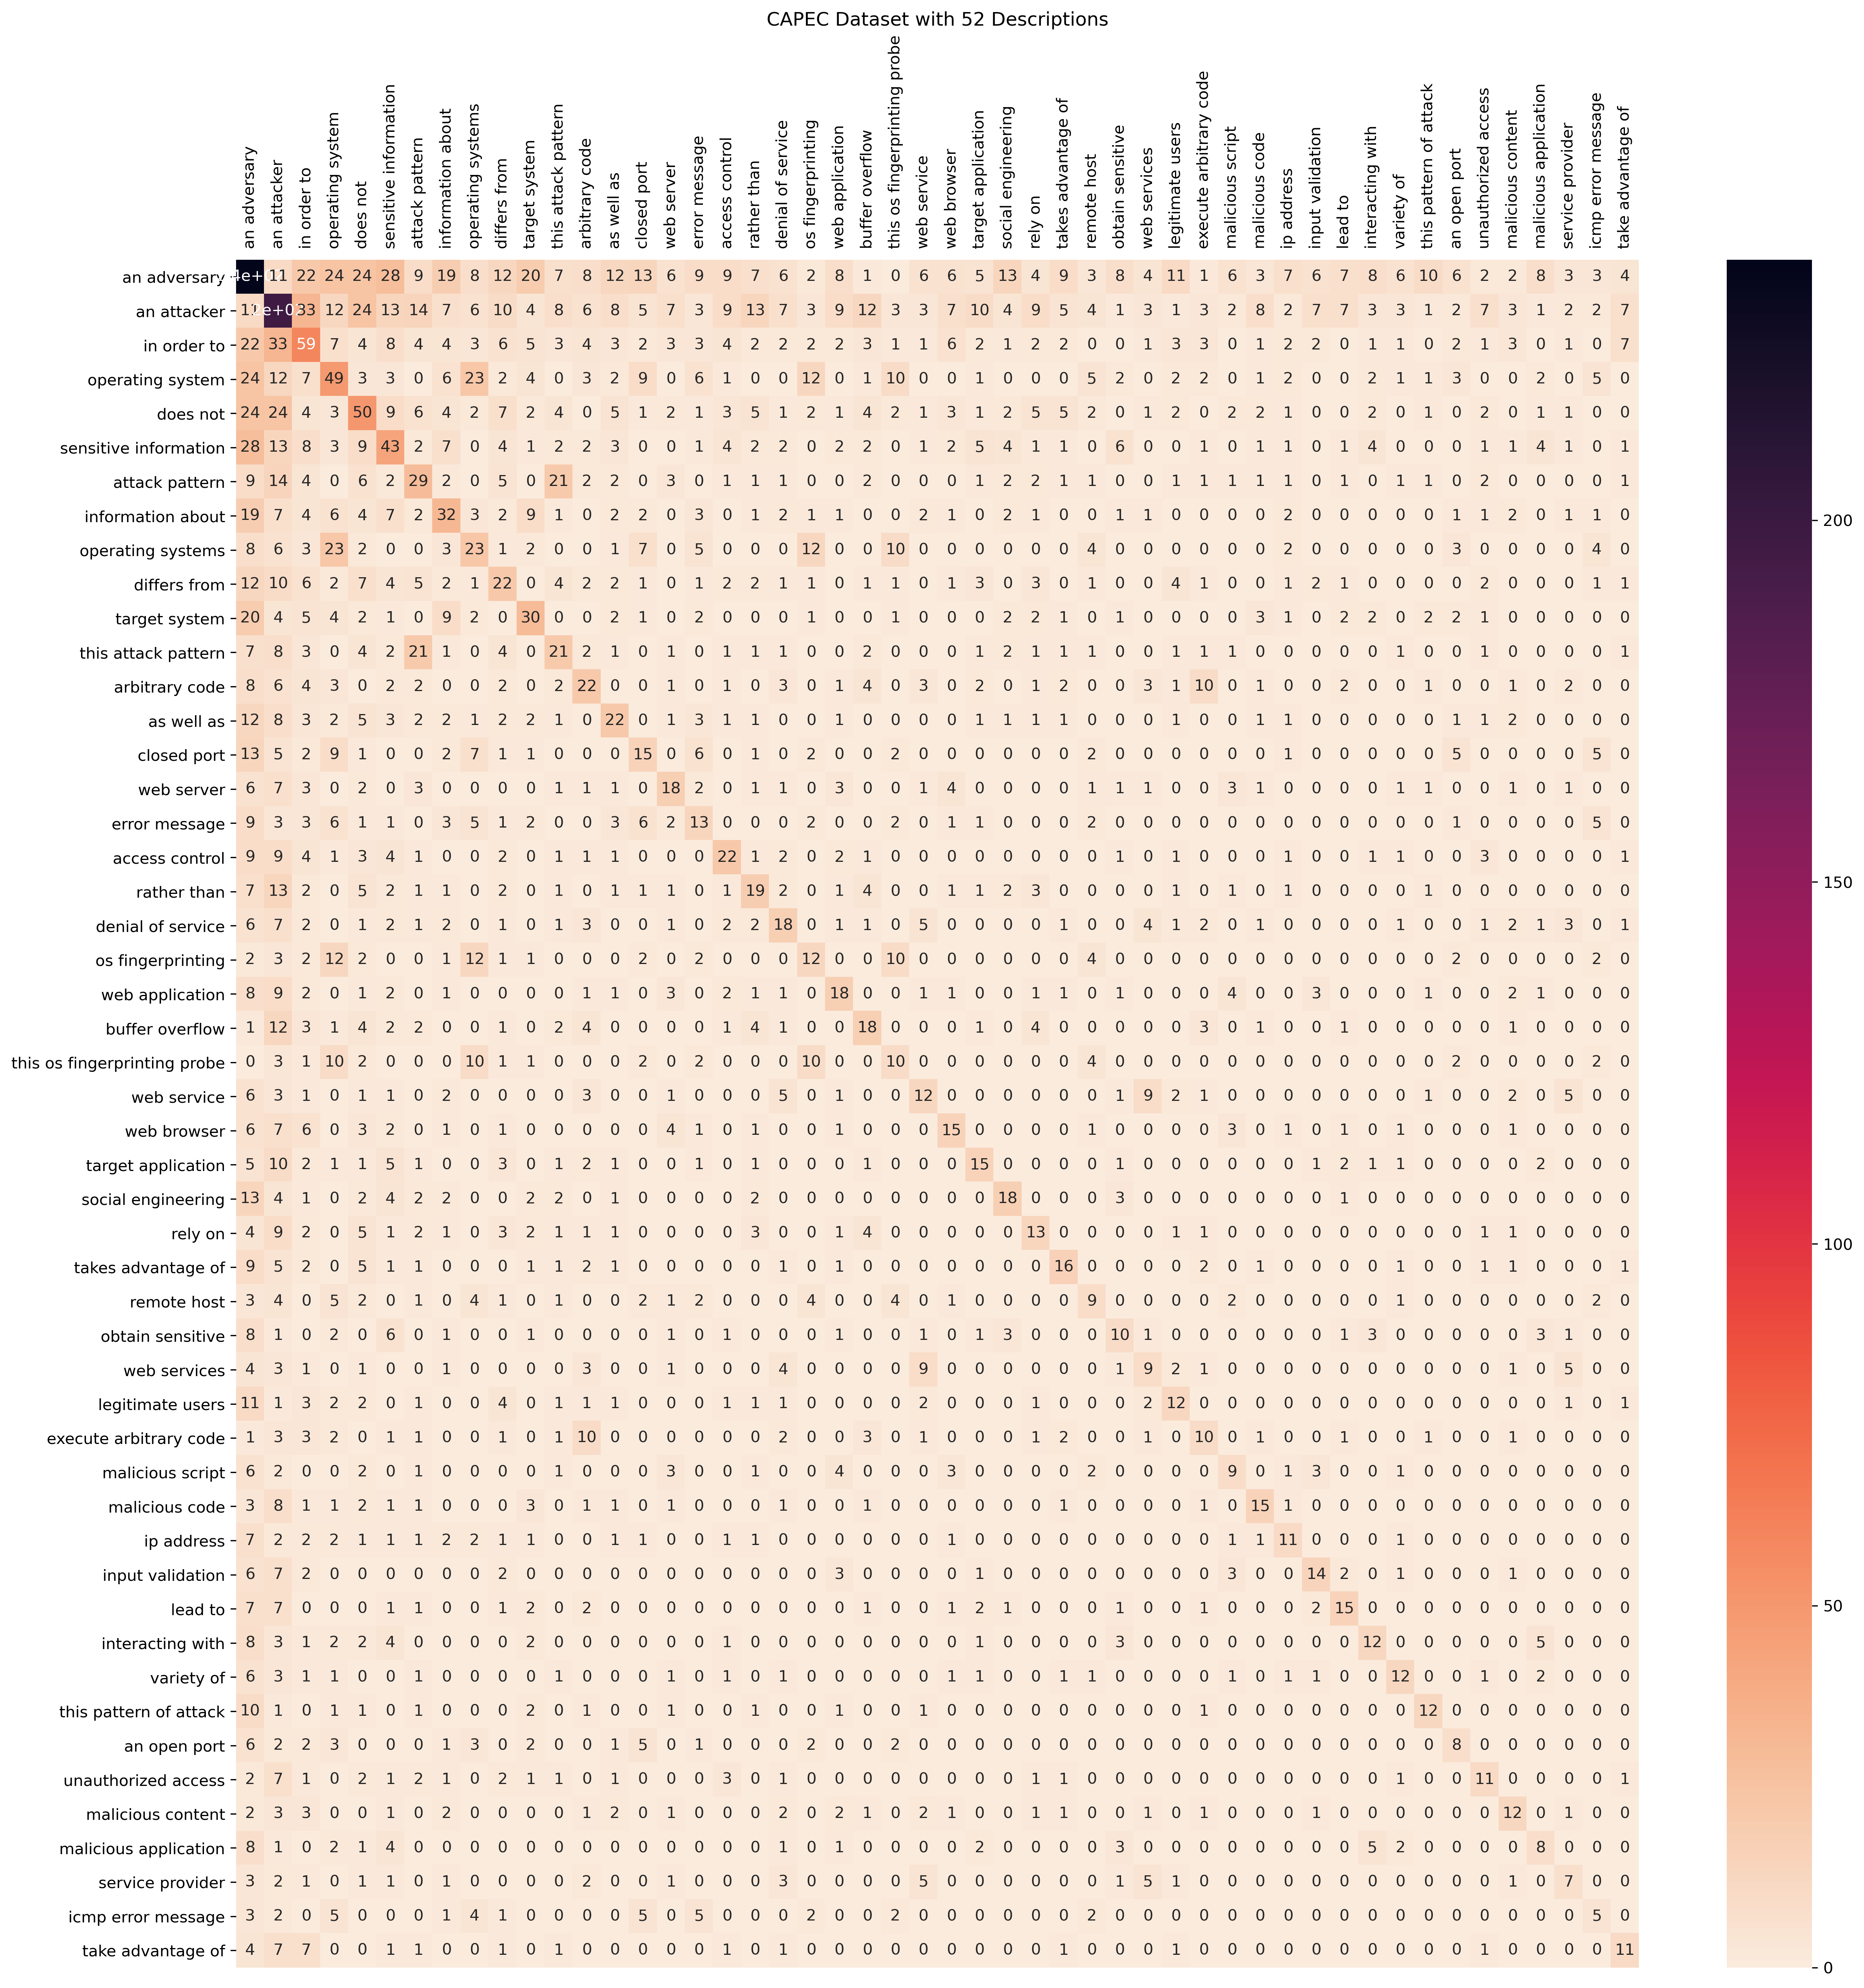

In [25]:
df = data_matrix.iloc[0:50,0:50]
plt.figure(figsize=(20,20))
ax = sns.heatmap(df, annot=True, cmap="rocket_r")
#plt.figure(figsize=(25,25))
#plt.imshow(df)
#plt.colorbar()
#plt.xticks(range(len(df)),df.columns, rotation=90)
#plt.yticks(range(len(df)),df.index)
#plt.ylabel('Frequency')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90)
plt.title('CAPEC Dataset with 527 Descriptions')
#plt.grid()
plt.savefig('data/matrix_images/CAPEC_matrix_th3.jpg')
plt.show()

## Save Sorted Data Matrix to CSV

In [26]:
data_matrix.to_csv('data/matrix_csv/CAPEC_coocurrence_matrix_t3.csv')